# Análisis de Consumo Energético y Clustering con K-Means

## Objetivos del Cuaderno

1. **Clustering con K-Means**: Aplicar el algoritmo de K-Means para agrupar las viviendas en función de sus patrones de consumo energético.
6. **Validación del Modelo**: Evaluar la calidad de los clusters generados utilizando metedos y visualizaciones adecuadas.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [33]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')
df_features_final = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')

In [34]:
X = df.values
which_model = "sc" #Choose beetween "bkmeans" or "kmeans" or "spectral_clustering"

In [35]:
if which_model == "bkmeans":
    with open("pkls/bkmeans_model.pkl", "rb") as f:
            model_final = pickle.load(f)

    if hasattr(model_final, 'labels_'):
        labels = model_final.labels_

    if hasattr(model_final, 'cluster_centers_'):
        centroids = model_final.cluster_centers_
elif which_model == "kmeans":
    with open("pkls/kmeans_model.pkl", "rb") as f:
        model_final = pickle.load(f)

    if hasattr(model_final, 'labels_'):
        labels = model_final.labels_

    if hasattr(model_final, 'cluster_centers_'):
        centroids = model_final.cluster_centers_
elif which_model == "sc":
    with open("pkls/spectral_clustering_model.pkl", "rb") as f:
        model_final = pickle.load(f)

    if hasattr(model_final, 'labels_'):
        labels = model_final.labels_
else:
    raise ValueError("Invalid model choice. Choose 'bkmeans', 'kmeans'")


In [36]:
best_k = model_final.n_clusters

## Árbol de Decisión para Interpretar Clusters

### **Objetivo**  
Crear un árbol de decisión que explique cómo se asignaron los clusters de tu modelo KMeans, usando reglas comprensibles en unidades originales.

#### Pasos: 
1. **Entrenar un árbol de decisión**  
   - **Variables predictoras**: Features originales (sin normalizar).  
2. **Garantizar interpretabilidad**  
   - Limitar la profundidad del árbol (`max_depth=5`).  
   - Asegurar que todos los clusters aparezcan en las hojas.  
3. **Generar reglas de negocio**  


In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_text

In [38]:
X = df_features_final
y = labels

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=42)

### Explicaciónde las variables del Árbol de Decisión
**Valores de cada nodo**
1. values = [a, b, c]
- Qué es:  
  - Número de muestras en cada cluster.  
  - Ejemplo: [30, 10, 5] → 30 en Cluster 0, 10 en Cluster 1, 5 en Cluster 2.
2. gini = X.XX  
- Qué es:  
  - "Suciedad" del nodo:  
    - 0 = Perfectamente ordenado (todas las muestras son del mismo cluster).  
    - ~0.5 = Muy mezclado (varios clusters balanceados).  
3. Consumo <= 150 (ejemplo)  
- Qué es:    
  - Regla de división: Si el valor es ≤ 150, sigue por la izquierda; si no, por la derecha.
4. samples = XX
- Qué es:   
  - Total de muestras en ese nodo.
5. cluster = X 
- Qué es:   
  - Cluster que predomina.

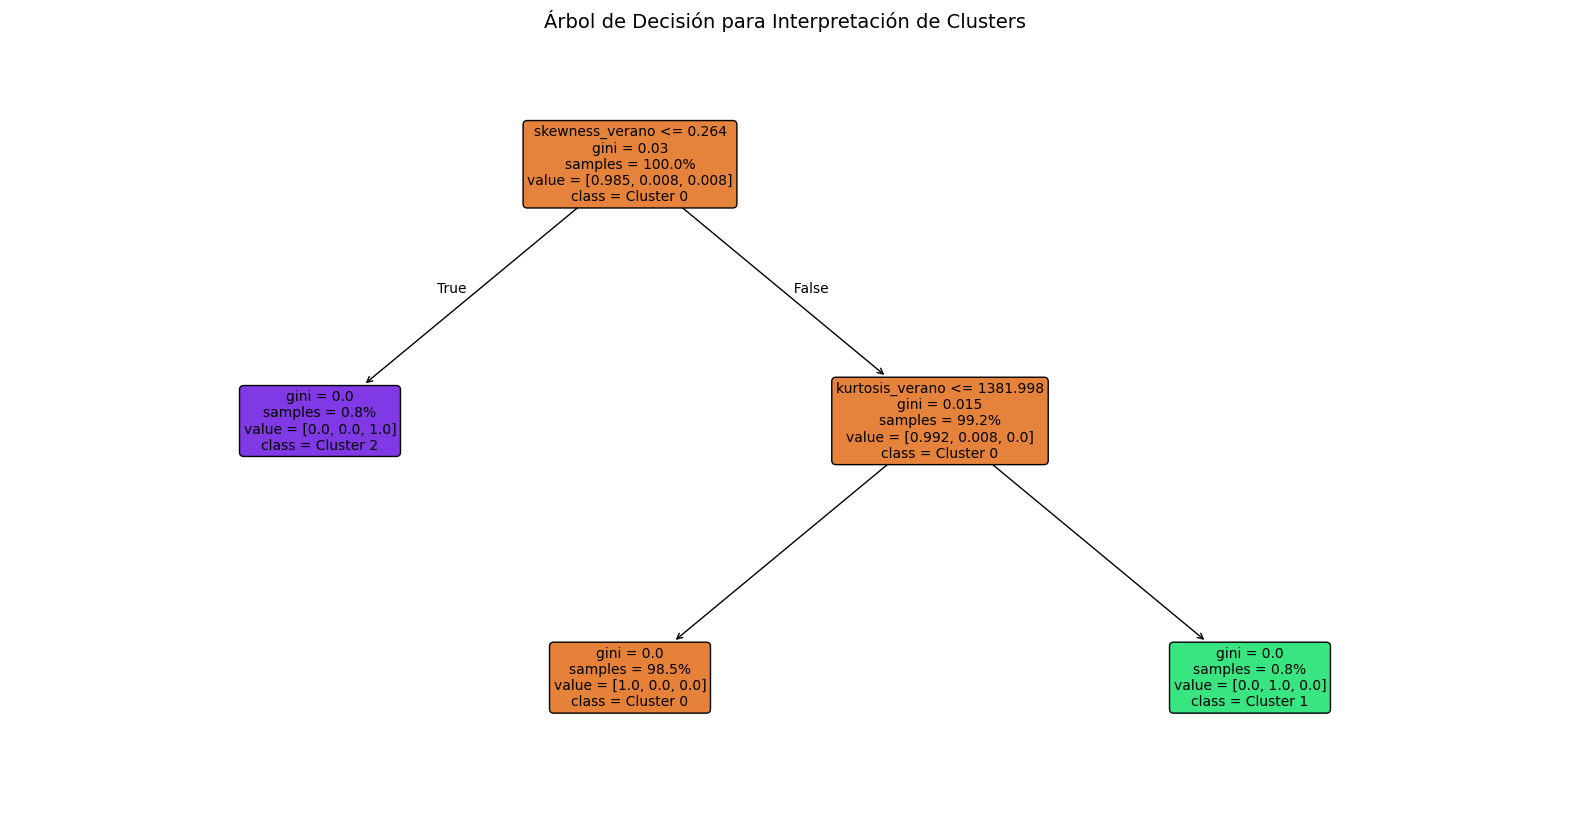

In [40]:
plt.figure(figsize=(20, 10))
plot_tree(tree,
          feature_names=X.columns,
          class_names=[f'Cluster {i}' for i in range(best_k)],
          filled=True,
          rounded=True,
          proportion=True,
          fontsize=10)
plt.title('Árbol de Decisión para Interpretación de Clusters', fontsize=14)
plt.show()

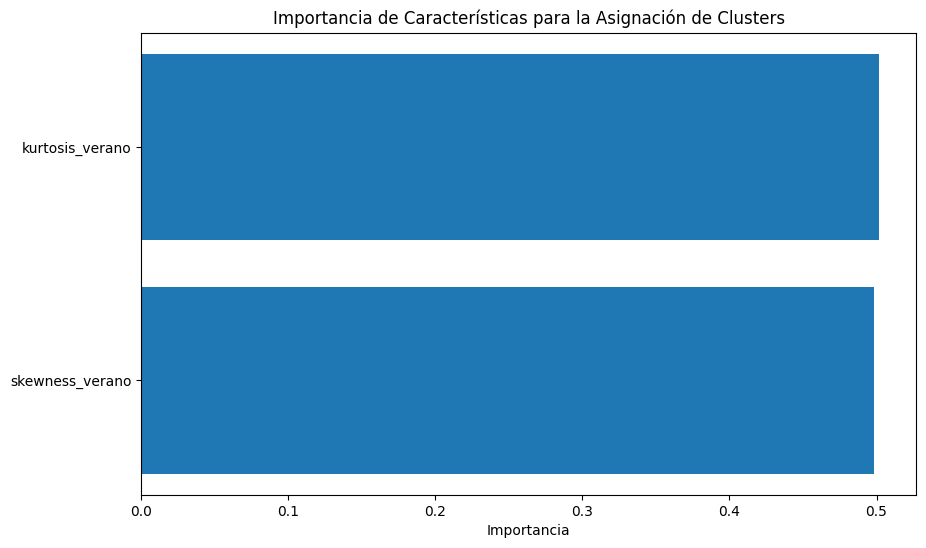

In [41]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': tree.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance = feature_importance[feature_importance['Importance'] > 0]

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importancia')
plt.title('Importancia de Características para la Asignación de Clusters')
plt.gca().invert_yaxis()
plt.show()

In [42]:
tree_rules = export_text(tree,
                        feature_names=list(X.columns),
                        spacing=3,
                        decimals=2)
print(tree_rules)

|--- skewness_verano <= 0.26
|   |--- class: 2
|--- skewness_verano >  0.26
|   |--- kurtosis_verano <= 1382.00
|   |   |--- class: 0
|   |--- kurtosis_verano >  1382.00
|   |   |--- class: 1

